https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html

In [17]:
# import the dataset from Sklearn

from sklearn.datasets import load_boston
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import shap
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical 

In [18]:
max_display=13

# Loading the data

In [19]:
target = load_boston().target
# re to real
target = np.multiply(target, 1000)
target = target.astype(int)
target

array([24000, 21600, 34700, 33400, 36200, 28700, 22900, 27100, 16500,
       18900, 15000, 18900, 21700, 20400, 18200, 19900, 23100, 17500,
       20200, 18200, 13600, 19600, 15200, 14500, 15600, 13900, 16600,
       14800, 18400, 21000, 12700, 14500, 13200, 13100, 13500, 18900,
       20000, 21000, 24700, 30800, 34900, 26600, 25300, 24700, 21200,
       19300, 20000, 16600, 14400, 19400, 19700, 20500, 25000, 23400,
       18900, 35400, 24700, 31600, 23300, 19600, 18700, 16000, 22200,
       25000, 33000, 23500, 19400, 22000, 17400, 20900, 24200, 21700,
       22800, 23400, 24100, 21400, 20000, 20800, 21200, 20300, 28000,
       23900, 24800, 22900, 23900, 26600, 22500, 22200, 23600, 28700,
       22600, 22000, 22900, 25000, 20600, 28400, 21400, 38700, 43800,
       33200, 27500, 26500, 18600, 19300, 20100, 19500, 19500, 20400,
       19800, 19400, 21700, 22800, 18800, 18700, 18500, 18300, 21200,
       19200, 20400, 19300, 22000, 20300, 20500, 17300, 18800, 21400,
       15700, 16200,

In [20]:
# Read the Data

df = pd.DataFrame(load_boston().data, columns=load_boston().feature_names)
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


In [21]:
#rename columns so they are understandable

df = df.rename(columns={"CRIM": "per capita crime rate by town", "ZN": "proportion of residential land big", 
                   "INDUS": "proportion of non-retail business", "CHAS": "next to river", 
                   "NOX": "nitric oxides concentration", "RM": "average number of rooms", 
                   "AGE": "proportion of owner-occupied long time", "DIS": "distances to five Boston employment centres", 
                   "RAD": "accessibility to radial highways", "TAX": "full-value property-tax rate", 
                   "PTRATIO": "pupil-teacher ratio by town", "B": "proportion of blacks per town", 
                   "LSTAT": "percentage lower status of population"})

# Transforming tha data

In [22]:
X = df
X

,per capita crime rate by town,proportion of residential land big,proportion of non-retail business,next to river,nitric oxides concentration,average number of rooms,proportion of owner-occupied long time,distances to five Boston employment centres,accessibility to radial highways,full-value property-tax rate,pupil-teacher ratio by town,proportion of blacks per town,percentage lower status of population
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


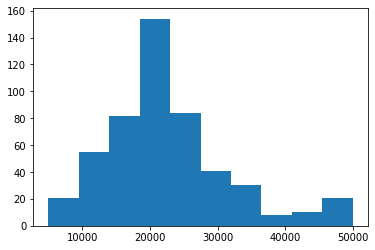

In [23]:
plt.figure()
plt.hist(target)

plt.show()

# Building and training the model

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.3, random_state=42)  # create train and test

In [28]:
# build model - Xgboost

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [29]:
# make prediction and check model accuracy

y_pred = model.predict(X_test)
y_pred

array([28648.96004632, 36495.01384349, 15411.1931992 , 25403.21303378,
       18855.2798756 , 23146.68943619, 17392.12409821, 14078.59899001,
       23036.92679157, 20599.4334475 , 24822.86159233, 18530.57048937,
       -6865.43526991, 21801.72334232, 19225.71177235, 26191.91984597,
       20277.33882373,  5615.96432299, 40448.87973513, 17576.95918288,
       27443.19094881, 30171.59640043, 10940.55822521, 24020.83138648,
       18076.93812361, 15934.74800487, 23126.14027798, 14560.52142167,
       22334.82543586, 19325.76269721, 22165.64973253, 25194.76080856,
       25313.7247263 , 18513.45025149, 16622.32859938, 17502.68505219,
       30949.92990855, 20192.01752401, 23904.40430835, 24869.75466433,
       13937.67876352, 31825.04715087, 42569.78796255, 17623.23805388,
       27019.63241621, 17190.06620635, 13805.94005697, 26103.56556699,
       20315.16117777, 30086.49576099, 21312.40530151, 34157.39601559,
       15604.44980994, 26112.47587849, 39316.13646448, 22992.82064916,
      

In [30]:
# Performance

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

r2_score(y_test, y_pred)

0.711226005748494

In [31]:
print("Model coefficients:\n")
for i in range(X.shape[1]):
    print(X.columns[i], "=", model.coef_[i].round(4))

Model coefficients:

per capita crime rate by town = -133.4701
proportion of residential land big = 35.8089
proportion of non-retail business = 49.5226
next to river = 3119.8351
nitric oxides concentration = -15417.0609
average number of rooms = 4057.1992
proportion of owner-occupied long time = -10.8208
distances to five Boston employment centres = -1385.9982
accessibility to radial highways = 242.7273
full-value property-tax rate = -8.7022
pupil-teacher ratio by town = -910.6852
proportion of blacks per town = 11.7941
percentage lower status of population = -547.1133


# Visualizations

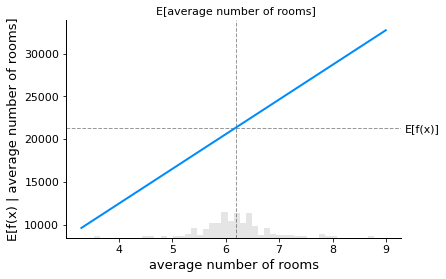

In [38]:
shap.plots.partial_dependence(
    "per capita crime rate by town", model.predict, X_test, ice=False,
    model_expected_value=True, feature_expected_value=True
)

In [51]:
# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, X_test)
shap_values = explainer(X)

sample_ind = 18

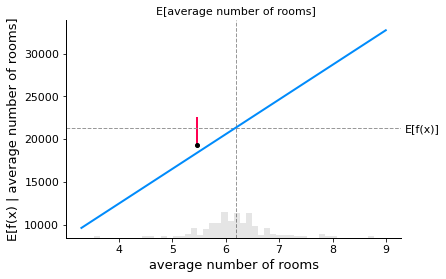

In [52]:
# make a standard partial dependence plot
shap.partial_dependence_plot(
    "average number of rooms", model.predict, X_test, model_expected_value=True,
    feature_expected_value=True, ice=False,
    shap_values=shap_values[sample_ind:sample_ind+1,:])

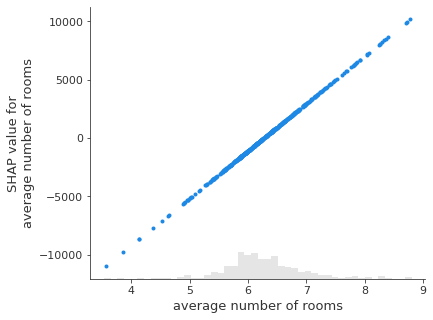

In [53]:
shap.plots.scatter(shap_values[:,"average number of rooms"])

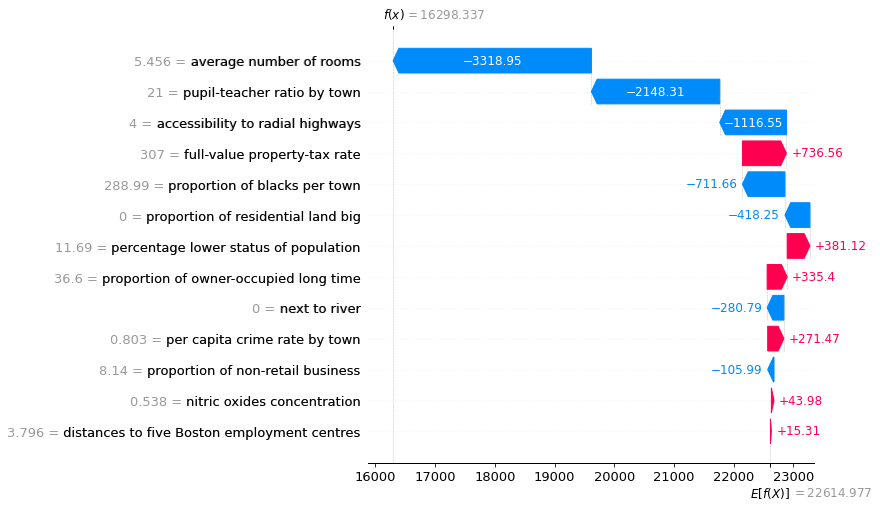

In [54]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

In [59]:
# fit a GAM model to the data
import interpret.glassbox
model_ebm = interpret.glassbox.ExplainableBoostingRegressor()
model_ebm.fit(X_train, y_train)

Permutation explainer:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 458/506 [00:35<00:07,  6.14it/s]


ExplainableBoostingRegressor(feature_names=['per capita crime rate by town',
                                            'proportion of residential land '
                                            'big',
                                            'proportion of non-retail business',
                                            'next to river',
                                            'nitric oxides concentration',
                                            'average number of rooms',
                                            'proportion of owner-occupied long '
                                            'time',
                                            'distances to five Boston '
                                            'employment centres',
                                            'accessibility to radial highways',
                                            'full-value property-tax rate',
                                            'pu...
                            

In [60]:
# explain the GAM model with SHAP
explainer_ebm = shap.Explainer(model_ebm.predict, X_test)
shap_values_ebm = explainer_ebm(X)

Permutation explainer: 507it [00:21, 12.61it/s]                                                                                                                                                                                           


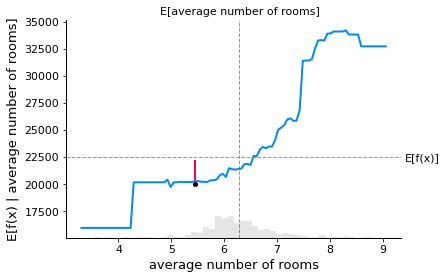

In [62]:
# make a standard partial dependence plot with a single SHAP value overlaid
fig,ax = shap.partial_dependence_plot(
    "average number of rooms", model_ebm.predict, X, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False,
    shap_values=shap_values_ebm[sample_ind:sample_ind+1,:]
)

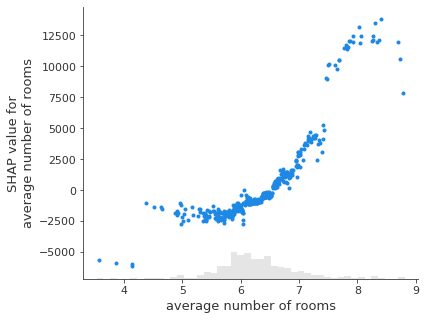

In [63]:
shap.plots.scatter(shap_values_ebm[:,"average number of rooms"])

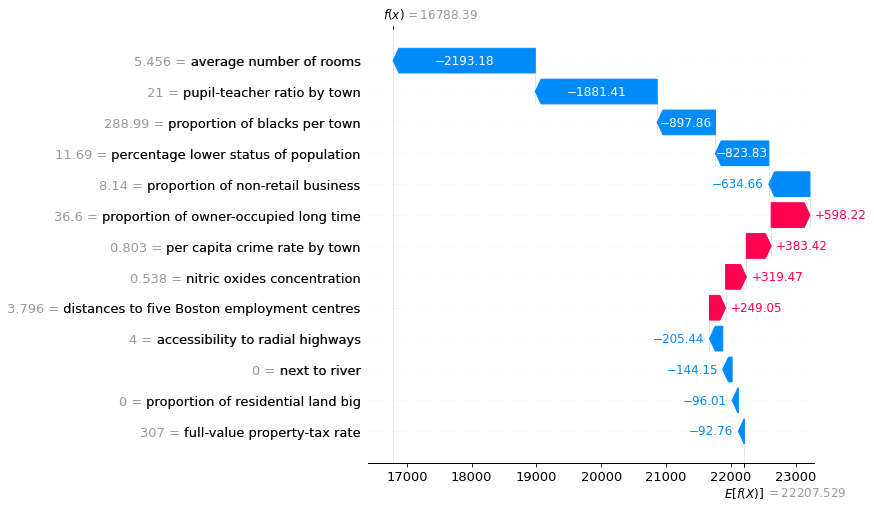

In [64]:
# the waterfall_plot shows how we get from explainer.expected_value to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values_ebm[sample_ind], max_display=14)

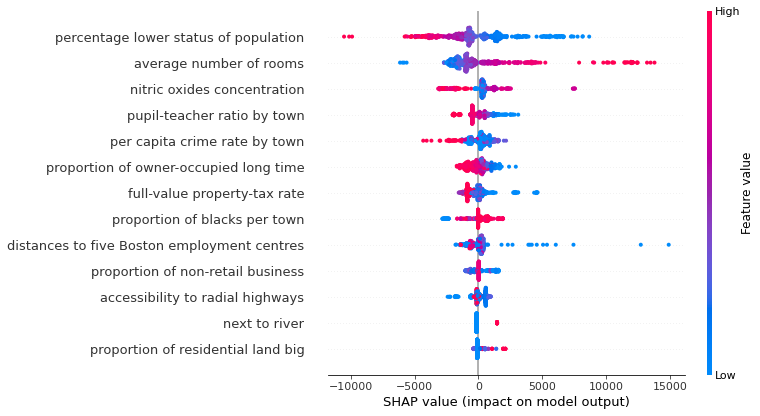

In [65]:
# the waterfall_plot shows how we get from explainer.expected_value to model.predict(X)[sample_ind]
shap.plots.beeswarm(shap_values_ebm, max_display=14)